In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('./data/second_innings.csv')
df

,match_id,venue,innings,ball,batting_team,bowling_team,runs_off_bat,extras,wides,noballs,byes,legbyes,wicket_type,runs_required,wickets_remaining,balls_remaining,crr,rrr,winner
0,1283048,Gahanga International Cricket Stadium. Rwanda,2,0.1,Mozambique,Botswana,0,0,NaN,NaN,NaN,NaN,caught,153.0,9.0,119.0,0.00,7.71,0.0
1,1283048,Gahanga International Cricket Stadium. Rwanda,2,0.2,Mozambique,Botswana,0,0,NaN,NaN,NaN,NaN,NaN,153.0,9.0,118.0,0.00,7.78,0.0
2,1283048,Gahanga International Cricket Stadium. Rwanda,2,0.3,Mozambique,Botswana,1,0,NaN,NaN,NaN,NaN,NaN,152.0,9.0,117.0,2.00,7.79,0.0
3,1283048,Gahanga International Cricket Stadium. Rwanda,2,0.4,Mozambique,Botswana,0,0,NaN,NaN,NaN,NaN,NaN,152.0,9.0,116.0,1.50,7.86,0.0
4,1283048,Gahanga International Cricket Stadium. Rwanda,2,0.5,Mozambique,Botswana,0,0,NaN,NaN,NaN,NaN,NaN,152.0,9.0,115.0,1.20,7.93,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232390,1384584,Marsa Sports Club,2,19.2,Luxembourg,Malta,1,0,NaN,NaN,NaN,NaN,NaN,68.0,1.0,4.0,6.62,102.00,0.0
232391,1384584,Marsa Sports Club,2,19.3,Luxembourg,Malta,2,0,NaN,NaN,NaN,NaN,NaN,66.0,1.0,3.0,6.67,132.00,0.0
232392,1384584,Marsa Sports Club,2,19.4,Luxembourg,Malta,2,0,NaN,NaN,NaN,NaN,NaN,64.0,1.0,2.0,6.71,192.00,0.0
232393,1384584,Marsa Sports Club,2,19.5,Luxembourg,Malta,1,0,NaN,NaN,NaN,NaN,NaN,63.0,1.0,1.0,6.71,378.00,0.0


In [3]:
df.drop(columns=['venue', 'innings', 'ball', 'batting_team', 'bowling_team', 'runs_off_bat', 'extras', 'wides', 'noballs', 'byes', 'legbyes', 'wicket_type'], inplace=True)
df.head()

,match_id,runs_required,wickets_remaining,balls_remaining,crr,rrr,winner
0,1283048,153.0,9.0,119.0,0.0,7.71,0.0
1,1283048,153.0,9.0,118.0,0.0,7.78,0.0
2,1283048,152.0,9.0,117.0,2.0,7.79,0.0
3,1283048,152.0,9.0,116.0,1.5,7.86,0.0
4,1283048,152.0,9.0,115.0,1.2,7.93,0.0


In [4]:
df.isna().sum()

match_id                0
runs_required           0
wickets_remaining       0
balls_remaining         0
crr                     0
rrr                     0
winner               3482
dtype: int64

In [5]:
df.dropna(inplace=True)

In [6]:
df.isna().sum()

match_id             0
runs_required        0
wickets_remaining    0
balls_remaining      0
crr                  0
rrr                  0
winner               0
dtype: int64

In [7]:
df.shape

(228913, 7)

In [8]:
df['runs_required'] = df['runs_required'].astype('int')
df['wickets_remaining'] = df['wickets_remaining'].astype('int')
df['balls_remaining'] = df['balls_remaining'].astype('int')
df['winner'] = df['winner'].astype('int')

In [9]:
df.head()

,match_id,runs_required,wickets_remaining,balls_remaining,crr,rrr,winner
0,1283048,153,9,119,0.0,7.71,0
1,1283048,153,9,118,0.0,7.78,0
2,1283048,152,9,117,2.0,7.79,0
3,1283048,152,9,116,1.5,7.86,0
4,1283048,152,9,115,1.2,7.93,0


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

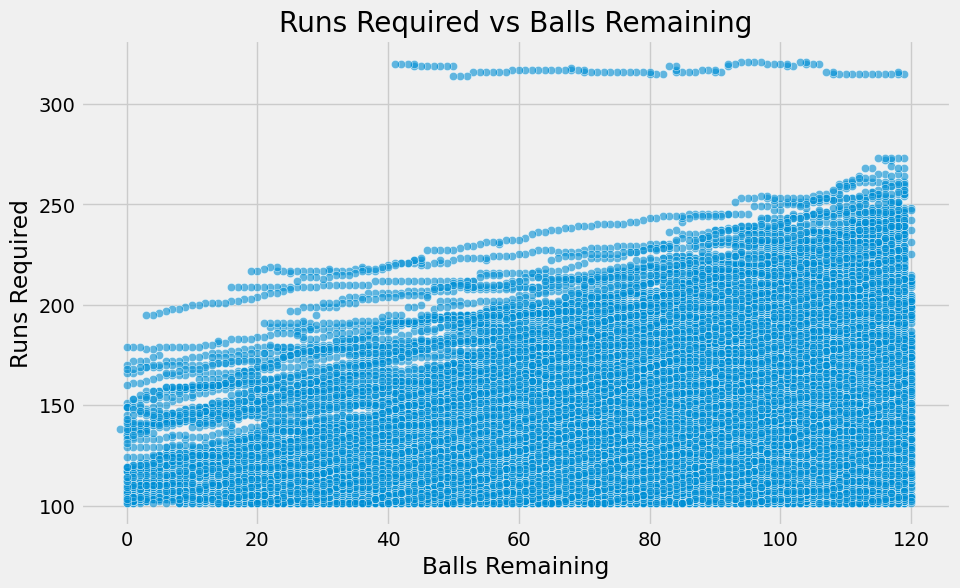

In [11]:
# scatter plot for runs required with minimum runs 100 vs balls remaining
plt.figure(figsize=(10, 6))
sns.scatterplot(x='balls_remaining', y='runs_required', data=df[(df['runs_required'] > 100)], alpha=0.6)
plt.title('Runs Required vs Balls Remaining')
plt.xlabel('Balls Remaining')
plt.ylabel('Runs Required')
plt.show()

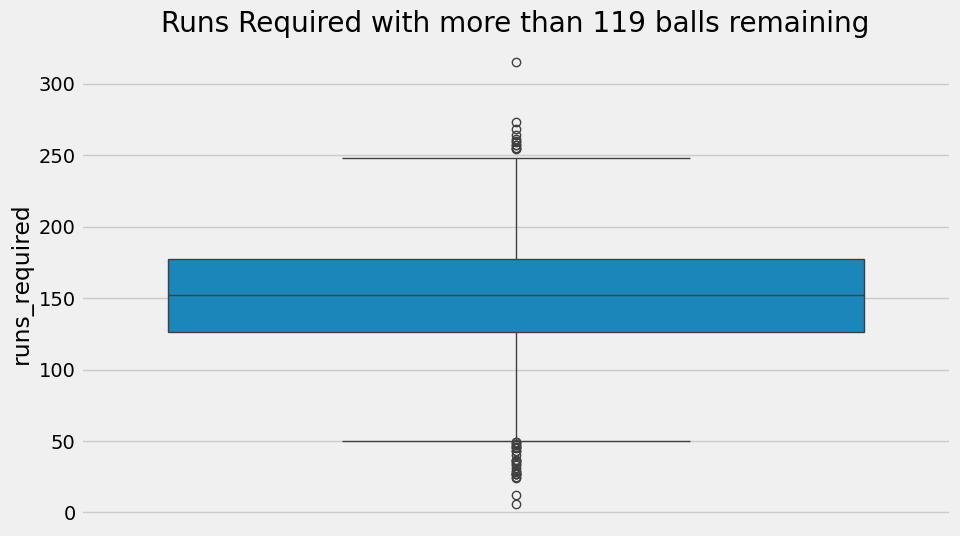

In [12]:
# boxplot for runs remaining with more than 119 balls remaining
plt.figure(figsize=(10, 6))
sns.boxplot(y='runs_required', data=df[(df['balls_remaining'] >= 119)])
plt.title('Runs Required with more than 119 balls remaining')
plt.show()

In [13]:
# get q1, q2, q3 for runs remaining with more than 119 balls remaining
q1 = df[(df['balls_remaining'] >= 119)]['runs_required'].quantile(0.25)
q2 = df[(df['balls_remaining'] >= 119)]['runs_required'].quantile(0.5)
q3 = df[(df['balls_remaining'] >= 119)]['runs_required'].quantile(0.75)

print(f'Q1: {q1}, Q2: {q2}, Q3: {q3}')

iqr = q3 - q1

# get lower and upper bounds
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

print(f'Lower Bound: {lower_bound}, Upper Bound: {upper_bound}')

Q1: 126.0, Q2: 152.0, Q3: 177.0
Lower Bound: 49.5, Upper Bound: 253.5


In [14]:
# find match_id for outliers accordingly
outliers = df[(df['balls_remaining'] >= 119)][(df['runs_required'] < lower_bound) | (df['runs_required'] > upper_bound)]

outlier_matches = outliers['match_id'].unique()

outlier_matches

/tmp/ipykernel_21859/3550993586.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = df[(df['balls_remaining'] >= 119)][(df['runs_required'] < lower_bound) | (df['runs_required'] > upper_bound)]


array([1322001, 1168113, 1320974, 1200425, 1354803, 1176796, 1273723,
       1322003, 1307478, 1332506, 1399104, 1283030, 1343749, 1418543,
        682933, 1418541, 1184901, 1343756,  287860, 1383103, 1299577,
        995467, 1383101, 1343763, 1373582, 1403305, 1122730, 1339605,
       1400988, 1310177, 1343760])

In [15]:
df[df['match_id'].isin(outlier_matches)]

,match_id,runs_required,wickets_remaining,balls_remaining,crr,rrr,winner
7807,1322001,31,9,119,0.00,1.56,1
7808,1322001,31,9,118,0.00,1.58,1
7809,1322001,31,9,117,0.00,1.59,1
7810,1322001,30,9,116,1.50,1.55,1
7811,1322001,29,9,115,2.40,1.51,1
...,...,...,...,...,...,...,...
224364,1343760,6,10,102,10.67,0.35,1
224365,1343760,4,10,101,10.74,0.24,1
224366,1343760,4,10,100,10.20,0.24,1
224367,1343760,3,10,99,10.00,0.18,1


In [16]:
# drop where match id is in outlier_matches
df = df[~df['match_id'].isin(outlier_matches)]
df

,match_id,runs_required,wickets_remaining,balls_remaining,crr,rrr,winner
0,1283048,153,9,119,0.00,7.71,0
1,1283048,153,9,118,0.00,7.78,0
2,1283048,152,9,117,2.00,7.79,0
3,1283048,152,9,116,1.50,7.86,0
4,1283048,152,9,115,1.20,7.93,0
...,...,...,...,...,...,...,...
232390,1384584,68,1,4,6.62,102.00,0
232391,1384584,66,1,3,6.67,132.00,0
232392,1384584,64,1,2,6.71,192.00,0
232393,1384584,63,1,1,6.71,378.00,0


In [24]:
# preprocessing for model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X = df[['runs_required', 'wickets_remaining', 'crr', 'rrr', 'balls_remaining']]
y = df['winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
# logistic regression model
from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import Pipeline

# pipe = Pipeline(steps=[('scaler', trf), ('model', LogisticRegression())])

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [26]:
accuracy = model.score(X_test, y_test)
accuracy

0.8183160028198802

In [27]:
X_test[10]

array([0.3373494 , 1.        , 0.1       , 0.26031812, 0.95041322])

In [28]:
model.predict_proba(X_test)[10]

array([0.02705534, 0.97294466])

In [32]:
# test for custom input
custom_data = [100, 5, 12, 6, 50]

# scale custom data
custom_data = scaler.transform([custom_data])

print(model.predict(custom_data))
print(model.predict_proba(custom_data))

[0]
[[0.82437492 0.17562508]]


/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

2024-03-20 07:56:31.511208: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-20 07:56:32.735394: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-20 07:56:35.694946: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 07:56:38.656056: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [36]:
model = Sequential()

model.add(Dense(5, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, verbose=1)

Epoch 1/10


5674/5674 ━━━━━━━━━━━━━━━━━━━━ 7s 934us/step - accuracy: 0.7686 - loss: 0.4803
Epoch 2/10
5674/5674 ━━━━━━━━━━━━━━━━━━━━ 10s 937us/step - accuracy: 0.8146 - loss: 0.3982
Epoch 3/10
5674/5674 ━━━━━━━━━━━━━━━━━━━━ 10s 910us/step - accuracy: 0.8139 - loss: 0.3984
Epoch 4/10
5674/5674 ━━━━━━━━━━━━━━━━━━━━ 5s 874us/step - accuracy: 0.8137 - loss: 0.3986
Epoch 5/10
5674/5674 ━━━━━━━━━━━━━━━━━━━━ 5s 919us/step - accuracy: 0.8148 - loss: 0.3953
Epoch 6/10
5674/5674 ━━━━━━━━━━━━━━━━━━━━ 5s 884us/step - accuracy: 0.8144 - loss: 0.3965
Epoch 7/10
5674/5674 ━━━━━━━━━━━━━━━━━━━━ 5s 920us/step - accuracy: 0.8141 - loss: 0.3946
Epoch 8/10
5674/5674 ━━━━━━━━━━━━━━━━━━━━ 10s 909us/step - accuracy: 0.8157 - loss: 0.3953
Epoch 9/10
5674/5674 ━━━━━━━━━━━━━━━━━━━━ 5s 883us/step - accuracy: 0.8156 - loss: 0.3936
Epoch 10/10
5674/5674 ━━━━━━━━━━━━━━━━━━━━ 5s 916us/step - accuracy: 0.8152 - loss: 0.3942


In [38]:
# predict
y_pred = model.predict(X_test)

accuracy = model.evaluate(X_test, y_test)
accuracy

1419/1419 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1419/1419 ━━━━━━━━━━━━━━━━━━━━ 1s 653us/step - accuracy: 0.8161 - loss: 0.3953


[0.3944542109966278, 0.8184481859207153]

In [41]:
# test for custom input
custom_data = [10, 5, 12, 6, 50]

# scale custom data
custom_data = scaler.transform([custom_data])

print(model.predict(custom_data))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
[[0.95429206]]


/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
